## Movie_Review_Sentiment_Classification+Sentence_Piece
### (영화리뷰 감성분석+Sentence Piece)

***
#### 1. 데이터 준비와 확인

In [1]:
import pandas as pd
import tensorflow as tf
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
print('학습데이터 문장의 갯수 : ',len(train_data['document']))
print('테스트데이터 문장의 갯수 : ',len(test_data['document']))

학습데이터 문장의 갯수 :  150000
테스트데이터 문장의 갯수 :  50000


**1) 학습/테스트데이터 중복제거**  

In [3]:
train_data.drop_duplicates(subset=['document'], inplace=True)
test_data.drop_duplicates(subset=['document'], inplace=True)
print('중복제거 후 학습데이터 문장의 갯수 : ',len(train_data['document']))
print('중복제거 후 테스트데이터 문장의 갯수 : ',len(test_data['document']))

중복제거 후 학습데이터 문장의 갯수 :  146183
중복제거 후 테스트데이터 문장의 갯수 :  49158


**2) 학습/테스트데이터 Nan 결측치 제거**  

In [4]:
train_data =train_data.dropna(how='any')
test_data =test_data.dropna(how='any')
print('걸측치제거 후 학습데이터 문장의 갯수 : ',len(train_data['document']))
print('결측치제거 후 테스트데이터 문장의 갯수 : ',len(test_data['document']))

걸측치제거 후 학습데이터 문장의 갯수 :  146182
결측치제거 후 테스트데이터 문장의 갯수 :  49157


**3) 문장 corpus 분석**  

문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


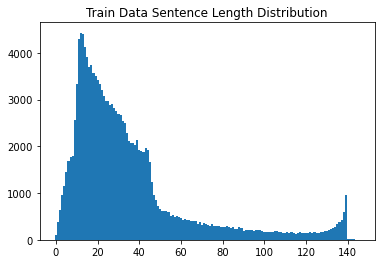

In [5]:
# 학습데이터로 SentencePiece를 학습하기위한 말뭉치 제작하기로 결정
min_len = 999
max_len = 0
sum_len = 0

for sen in train_data['document']:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(train_data['document']))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in train_data['document']:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Train Data Sentence Length Distribution")
plt.show()

In [6]:
cleaned_corpus = []
for sen in train_data['document']:
    cleaned_corpus.append(sen)

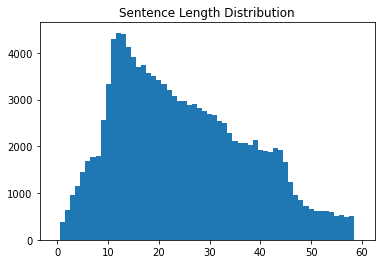

In [7]:
max_len = 60
min_len = 2

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

**4) SentencePiece 적용**  

In [8]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-rw-r-- 1 aiffel aiffel 375101  4월  8 02:00 korean_spm_bpe.model
-rw-rw-r-- 1 aiffel aiffel 144410  4월  8 02:00 korean_spm_bpe.vocab
-rw-rw-r-- 1 aiffel aiffel 375097  4월  8 02:14 korean_spm.model
-rw-rw-r-- 1 aiffel aiffel 144410  4월  8 02:14 korean_spm.vocab


**5) 토크나이저 구현**  

In [9]:
s = spm.SentencePieceProcessor()
print(s.Load('korean_spm.model'))
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

True


In [10]:
X_train = train_data['document']
X_test = test_data['document']

In [11]:
y_train = train_data['label']
y_test = test_data['label']

In [12]:
X_train_tensor, X_train_word_to_index, X_train_index_to_word = sp_tokenize(s,X_train)
X_test_tensor, X_test_word_to_index, X_test_index_to_word = sp_tokenize(s,X_train)

In [13]:
# validation set 28000건 분리(전체 data의 약 20%)
X_val = X_train_tensor[:28000]   
y_val = y_train[:28000]

# validation set을 제외한 나머지 118182건
partial_X_train = X_train_tensor[28000:]  
partial_y_train = y_train[28000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(118182, 133)
(118182,)


In [14]:
vocab_size = 8000
word_vector_dim = 16

In [15]:
model = keras.Sequential(name="LSTM")
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(32, return_sequences = True))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.LSTM(32, return_sequences = True))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          128000    
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          6272      
_________________________________________________________________
dropout (Dropout)            (None, None, 32)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
dense (Dense)                (None, None, 1)           33        
Total params: 142,625
Trainable params: 142,625
Non-trainable params: 0
________________________________________________________

In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=(X_val, y_val))

Epoch 1/30
231/231 [==============================] - 6s 28ms/step - loss: 0.5185 - accuracy: 0.7209 - val_loss: 0.3818 - val_accuracy: 0.8334
Epoch 2/30
231/231 [==============================] - 7s 29ms/step - loss: 0.3683 - accuracy: 0.8424 - val_loss: 0.3664 - val_accuracy: 0.8401
Epoch 3/30
231/231 [==============================] - 6s 26ms/step - loss: 0.3473 - accuracy: 0.8519 - val_loss: 0.3674 - val_accuracy: 0.8393
Epoch 4/30
231/231 [==============================] - 6s 24ms/step - loss: 0.3396 - accuracy: 0.8551 - val_loss: 0.3571 - val_accuracy: 0.8414
Epoch 5/30
231/231 [==============================] - 6s 26ms/step - loss: 0.3315 - accuracy: 0.8577 - val_loss: 0.3568 - val_accuracy: 0.8419
Epoch 6/30
231/231 [==============================] - 6s 27ms/step - loss: 0.3243 - accuracy: 0.8600 - val_loss: 0.3618 - val_accuracy: 0.8419
Epoch 7/30
231/231 [==============================] - 6s 25ms/step - loss: 0.3158 - accuracy: 0.8618 - val_loss: 0.3620 - val_accuracy: 0.8418

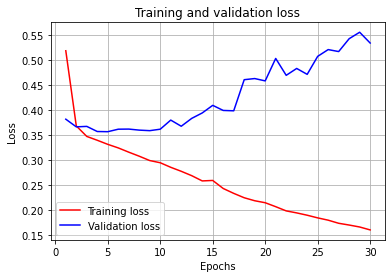

In [17]:
history_dict = history.history
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 빨간 실선으로 표시
plt.plot(epochs, loss, 'r', label='Training loss')
# 파란 실선으로 표시
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.show()

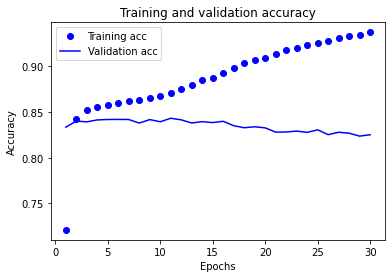

In [18]:
plt.clf() # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [19]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_bpe --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm_bpe*

-rw-rw-r-- 1 aiffel aiffel 375101  4월  8 02:17 korean_spm_bpe.model
-rw-rw-r-- 1 aiffel aiffel 144410  4월  8 02:17 korean_spm_bpe.vocab


In [20]:
s = spm.SentencePieceProcessor()
print(s.Load('korean_spm_bpe.model'))
def sp_tokenize_bpe(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm_bpe.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

True


In [21]:
X_train_tensor_bpe, X_train_word_to_index_bpe, X_train_index_to_word_bpe = sp_tokenize_bpe(s,X_train)
X_test_tensor_bpe, X_test_word_to_index_bpe, X_test_index_to_word_bpe = sp_tokenize_bpe(s,X_train)

In [22]:
# validation set 28000건 분리(전체 data의 약 20%)
X_val_bpe = X_train_tensor_bpe[:28000]   
y_val_bpe = y_train[:28000]

# validation set을 제외한 나머지 118182건
partial_X_train_bpe = X_train_tensor_bpe[28000:]  
partial_y_train_bpe = y_train[28000:]

print(partial_X_train_bpe.shape)
print(partial_y_train_bpe.shape)

(118182, 133)
(118182,)


In [23]:
model1 = keras.Sequential(name="LSTM")
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.LSTM(32, return_sequences = True))
model1.add(keras.layers.Dropout(0.3))
model1.add(keras.layers.LSTM(32, return_sequences = True))
model1.add(keras.layers.Dropout(0.3))
model1.add(keras.layers.Dense(1, activation='sigmoid'))

model1.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          128000    
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 32)          6272      
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           33        
Total params: 142,625
Trainable params: 142,625
Non-trainable params: 0
________________________________________________________

In [24]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(partial_X_train_bpe,
                    partial_y_train_bpe,
                    epochs=30,
                    batch_size=512,
                    validation_data=(X_val_bpe, y_val_bpe))

Epoch 1/30
231/231 [==============================] - 6s 28ms/step - loss: 0.1611 - accuracy: 0.9376 - val_loss: 0.5992 - val_accuracy: 0.8235
Epoch 2/30
231/231 [==============================] - 6s 25ms/step - loss: 0.1498 - accuracy: 0.9424 - val_loss: 0.5871 - val_accuracy: 0.8216
Epoch 3/30
231/231 [==============================] - 6s 27ms/step - loss: 0.1501 - accuracy: 0.9427 - val_loss: 0.5681 - val_accuracy: 0.8225
Epoch 4/30
231/231 [==============================] - 6s 26ms/step - loss: 0.1474 - accuracy: 0.9441 - val_loss: 0.5722 - val_accuracy: 0.8252
Epoch 5/30
231/231 [==============================] - 6s 24ms/step - loss: 0.1440 - accuracy: 0.9453 - val_loss: 0.6302 - val_accuracy: 0.8238
Epoch 6/30
231/231 [==============================] - 6s 25ms/step - loss: 0.1391 - accuracy: 0.9476 - val_loss: 0.6190 - val_accuracy: 0.8210
Epoch 7/30
231/231 [==============================] - 6s 25ms/step - loss: 0.1380 - accuracy: 0.9480 - val_loss: 0.6556 - val_accuracy: 0.8225

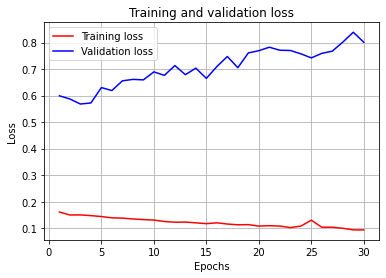

In [25]:
history_dict = history.history
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 빨간 실선으로 표시
plt.plot(epochs, loss, 'r', label='Training loss')
# 파란 실선으로 표시
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.show()

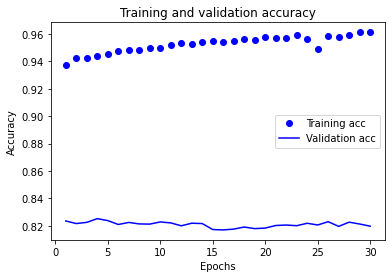

In [26]:
plt.clf() # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**unigram 방식**  
train_loss: 0.1604  
train_accuracy: 0.9374  
val_loss: 0.5340  
val_accuracy: 0.8252  
***
**bpe 방식**  
train_loss: 0.0935  
train_accuracy: 0.9613  
val_loss: 0.8011  
val_accuracy: 0.8197
***
### 회고록  
이전에 했던 네이버리뷰 감성분석의 확장판 같은 느낌이었다.  
비교적 최근에 개발된 SentencePice를 이용하여 형태소분석이 아닌 단위기반으로 분석을 진행하여 좀더 다양한 문장들을 처리할 수 있는 느낌이었다.  
그러나 기존의 mecab을 활용한 방식보다는 accuracy가 떨어지는 느낌이었다.  
좀더 많은 양의 corpus를 만들 수 있는 환경이 조성되어야 할 것 같았다.  
비록 학습은 과적합되는 경향을 보였지만 그래도 비교적 높은 수치의 accuracy를 얻을 수 있었다.  
좋은 학습 노드였다고 생각한다. 